In [1]:
import os
import numpy as np
import torch
import random
# setting seed

def seed_everything(seed):
    random.seed(seed) ##random module의 시드 고정
    os.environ['PYTHONHASHSEED'] = str(seed) #해시 함수의 랜덤성 제어, 자료구조 실행할 때 동일한 순서 고정
    np.random.seed(seed) #numpy 랜덤 숫자 일정
    torch.manual_seed(seed) # torch라이브러리에서 cpu 텐서 생성 랜덤 시드 고정
    torch.cuda.manual_seed(seed) # cuda의 gpu텐서에 대한 시드 고정
    torch.backends.cudnn.deterministic = True # 백엔드가 결정적 알고리즘만 사용하도록 고정 
    torch.backends.cudnn.benchmark = True # CuDNN이 여러 내부 휴리스틱을 사용하여 가장 빠른 알고리즘 동적으로 찾도록 설정

In [2]:
seed_everything(42)

In [3]:
import pandas as pd

df = pd.read_csv("./open (2)/train.csv")


In [4]:
print(df.head())

                  img_path                 upscale_img_path              label
0  ./train/TRAIN_00000.jpg  ./upscale_train/TRAIN_00000.png     Ruddy Shelduck
1  ./train/TRAIN_00001.jpg  ./upscale_train/TRAIN_00001.png       Gray Wagtail
2  ./train/TRAIN_00002.jpg  ./upscale_train/TRAIN_00002.png     Indian Peacock
3  ./train/TRAIN_00003.jpg  ./upscale_train/TRAIN_00003.png  Common Kingfisher
4  ./train/TRAIN_00004.jpg  ./upscale_train/TRAIN_00004.png  Common Kingfisher


In [5]:
CFG = {
    'IMG_SIZE': 224,
    'EPOCHS': 5,
    'LEARNING_RATE': 3e-4,
    'BATCH_SIZE': 4,
    'SEED': 42
}

In [6]:
from sklearn.model_selection import train_test_split
train, val, _, _ = train_test_split(df, df['label'],test_size=0.3,stratify=df['label'],random_state=CFG['SEED'])

In [7]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train['label'] = label_encoder.fit_transform(train['label'])
val['label'] = label_encoder.transform(val['label'])

In [8]:
#print(train['label'])
print(pd.value_counts(train['label']))

label
19    470
23    466
18    464
17    464
9     463
16    461
22    461
21    460
3     460
5     457
24    454
12    451
6     450
1     449
2     449
15    447
13    446
10    442
11    441
4     441
8     440
20    431
0     429
7     385
14    302
Name: count, dtype: int64


In [9]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import cv2
import torchvision
from torchvision import transforms

In [10]:
class CustomDataset(Dataset):
    def __init__(self,img_path_list, label_list, transforms = None):
        self.img_path_list = img_path_list
        self.label_list = label_list
        self.transforms = transforms
    def __getitem__(self, index):
        img_path = './open (2)' + self.img_path_list[index][1:] #csv 파일에 있는 경로와 내 컴퓨터 경로가 다름
        # image import
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transforms is not None:
            image = self.transforms(image)#['image']
        if self.label_list is not None:
            label = self.label_list[index]
            label_onehot = torch.eye(25)[label].float()
            return image, label_onehot
        else:
            return image

    def __len__(self):
        return len(self.img_path_list)
class UPCustomDataset(Dataset):
    def __init__(self,img_path_list, label_list, transforms = None):
        self.img_path_list = img_path_list
        self.label_list = label_list
        self.transforms = transforms
    def __getitem__(self, index):
        img_path = './open (2)' + self.img_path_list[index][1:] #csv 파일에 있는 경로와 내 컴퓨터 경로가 다름
        label_path = './open (2)' + self.label_list[index][1:]
        # image import
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = cv2.imread(label_path)
        label = cv2.cvtColor(label, cv2.COLOR_BGR2RGB)
        if self.transforms is not None:
            image = self.transforms(image)#['image']
            label = self.transforms(label)
        return image, label
        #if self.label_list is not None:
        #    label = self.label_list[index]
        #    return image, label
        #else:
        #    return image

    def __len__(self):
        return len(self.img_path_list)    
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(CFG['IMG_SIZE']),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(CFG['IMG_SIZE']),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

train_dataset = CustomDataset(train['img_path'].values, train['label'].values,train_transform)
train_loader = DataLoader(train_dataset,batch_size=CFG['BATCH_SIZE'],shuffle=True)

val_dataset = CustomDataset(val['img_path'].values, val['label'].values,test_transform)
val_loader = DataLoader(val_dataset,batch_size=CFG['BATCH_SIZE'],shuffle=False)


uptrain_dataset = UPCustomDataset(train['img_path'].values, train['upscale_img_path'].values,train_transform)
uptrain_loader = DataLoader(uptrain_dataset,batch_size=CFG['BATCH_SIZE'],shuffle=True)

upval_dataset = UPCustomDataset(val['img_path'].values, val['upscale_img_path'].values,test_transform)
upval_loader = DataLoader(upval_dataset,batch_size=CFG['BATCH_SIZE'],shuffle=False)

  0%|          | 0/2771 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


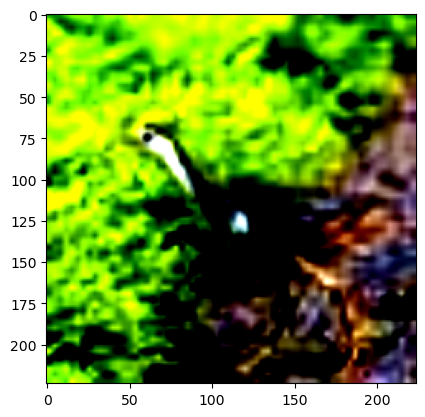

  0%|          | 0/2771 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


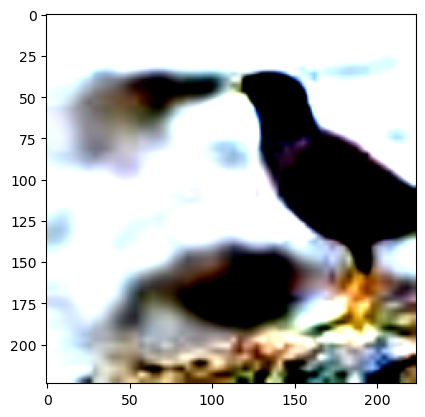

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


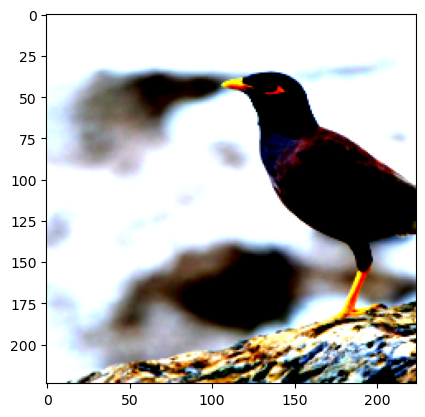

  0%|          | 0/2771 [00:00<?, ?it/s]


In [11]:
import matplotlib.pyplot as plt
from tqdm import tqdm
def custom_imshow(img):
    img = img.numpy()
    plt.imshow(np.transpose(img[0],(1,2,0))) #pytorch는 이미지 데이터셋을 batch size channel width height 순으로 저장
    #따라서 matplotlib으로 출력하고 싶다면 width height channel로 변경해줘야함 
    plt.show()
def process():
    for imgs, labels in tqdm(iter(train_loader)):

    
        
        custom_imshow(imgs)
        break
    for imgs, labels in tqdm(iter(uptrain_loader)):

    
        
        custom_imshow(imgs)
        custom_imshow(labels)
        break
process()

In [12]:
#train_loader : 저화질 
#uptrain_loader : 고화질
#U-Net을 만들어서 저화질 to 고화질 모델 생성

#U-Net 자주쓰는 함수
def conv_block(in_dim,out_dim,activation):
    model = nn.Sequential(
        nn.Conv2d(in_dim,out_dim,kernel_size=3,stride=1,padding=1),
        nn.BatchNorm2d(out_dim),
        activation
    )
    return model

def conv_trans_block(in_dim,out_dim,activation):
    model = nn.Sequential(
        nn.ConvTranspose2d(in_dim,out_dim,kernel_size=3,stride=2,padding=1,output_padding=1),
        nn.BatchNorm2d(out_dim),
        activation
    )
    return model

def maxpool():
    pool = nn.MaxPool2d(kernel_size=2,stride=2,padding=0)
    return pool

def conv_block_2(in_dim,out_dim,activation):
    model = nn.Sequential(
        conv_block(in_dim,out_dim,activation),
        nn.Conv2d(out_dim,out_dim,kernel_size=3,stride=1,padding=1),
        nn.BatchNorm2d(out_dim)
    )
    return model



In [13]:
class UnetGen(nn.Module):
    def __init__(self,in_dim,out_dim,num_filter):
        super(UnetGen,self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.num_filter = num_filter
        activation = nn.LeakyReLU(0.2,inplace=True)
        print('Initiating U-Net ...')

        self.down_1 = conv_block_2(self.in_dim,self.num_filter,activation)
        self.pool_1 = maxpool()
        self.down_2 = conv_block_2(self.num_filter*1,self.num_filter*2,activation)
        self.pool_2 = maxpool()
        self.down_3 = conv_block_2(self.num_filter*2,self.num_filter*4,activation)
        self.pool_3 = maxpool()
        self.down_4 = conv_block_2(self.num_filter*4,self.num_filter*8,activation)
        self.pool_4 = maxpool()

        self.bridge = conv_block_2(self.num_filter*8,self.num_filter*16,activation)

        self.trans_1 = conv_trans_block(self.num_filter*16,self.num_filter*8,activation)
        self.up_1 = conv_block_2(self.num_filter*16,self.num_filter*8,activation)
        self.trans_2 = conv_trans_block(self.num_filter*8,self.num_filter*4,activation)
        self.up_2 = conv_block_2(self.num_filter*8,self.num_filter*4,activation)
        self.trans_3 = conv_trans_block(self.num_filter*4,self.num_filter*2,activation)
        self.up_3 = conv_block_2(self.num_filter*4,self.num_filter*2,activation)
        self.trans_4 = conv_trans_block(self.num_filter*2,self.num_filter*1,activation)
        self.up_4 = conv_block_2(self.num_filter*2,self.num_filter*1,activation)
        
        self.out = nn.Sequential(
            nn.Conv2d(self.num_filter,self.out_dim,3,1,1),
            nn.Tanh(),  #필수는 아님
        )
        
            
    def forward(self,input):
        down_1 = self.down_1(input)
        pool_1 = self.pool_1(down_1)
        down_2 = self.down_2(pool_1)
        pool_2 = self.pool_2(down_2)
        down_3 = self.down_3(pool_2)
        pool_3 = self.pool_3(down_3)
        down_4 = self.down_4(pool_3)
        pool_4 = self.pool_4(down_4)

        bridge = self.bridge(pool_4)

        trans_1 = self.trans_1(bridge)
        concat_1 = torch.cat([trans_1,down_4],dim=1)
        up_1 = self.up_1(concat_1)
        trans_2 = self.trans_2(up_1)
        concat_2 = torch.cat([trans_2,down_3],dim=1)
        up_2 = self.up_2(concat_2)
        trans_3 = self.trans_3(up_2)
        concat_3 = torch.cat([trans_3,down_2],dim=1)
        up_3 = self.up_3(concat_3)
        trans_4 = self.trans_4(up_3)
        concat_4 = torch.cat([trans_4,down_1],dim=1)
        up_4 = self.up_4(concat_4)
        out = self.out(up_4)
        return out

In [14]:
img_size = CFG['IMG_SIZE']
in_dim = 3
out_dim = 3
num_filters = 64
num_epoch = 3
lr = 0.001

device = 'cuda:0'
# 앞서 정의한대로 vGG 클래스를 인스턴스화 하고 지정한 장치에 올립니다.



In [15]:
model = UnetGen(in_dim=in_dim,out_dim=out_dim,num_filter=num_filters).to('cpu')
model.load_state_dict(torch.load('./unet1'))


Initiating U-Net ...


<All keys matched successfully>

In [16]:
def custom_imshow(img):
    img = img.numpy()
    plt.imshow(np.transpose(img[0],(1,2,0))) #pytorch는 이미지 데이터셋을 batch size channel width height 순으로 저장
    #따라서 matplotlib으로 출력하고 싶다면 width height channel로 변경해줘야함 
    plt.show()
def process():
    for imgs, labels in tqdm(iter(val_loader)):

    
        
        custom_imshow(imgs)
        break
    for imgs, labels in tqdm(iter(upval_loader)):

    
        
        custom_imshow(imgs)
        custom_imshow(labels)
        break


  0%|          | 0/2771 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


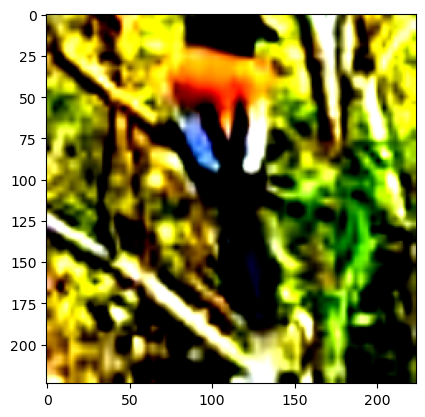

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


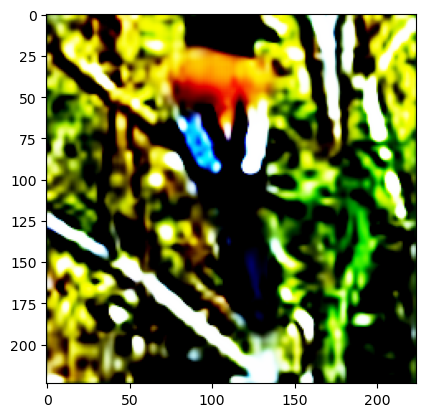

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


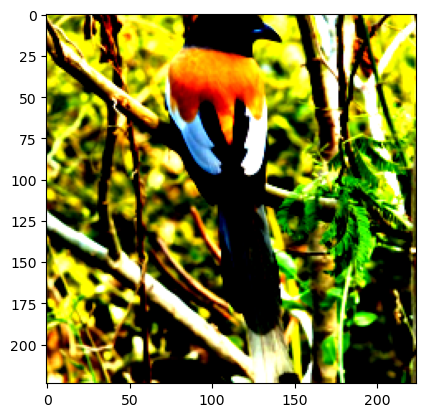

  0%|          | 1/2771 [00:01<51:27,  1.11s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


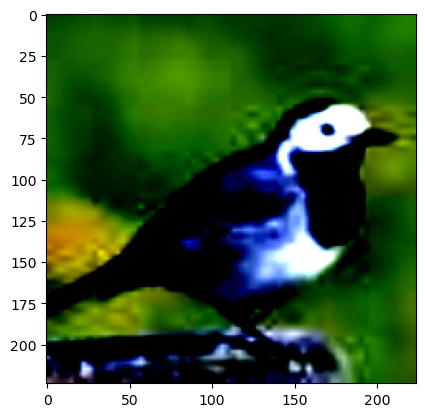

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


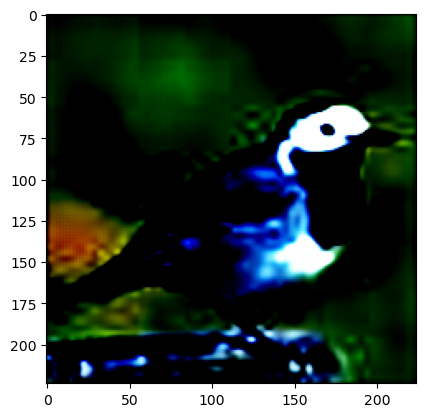

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


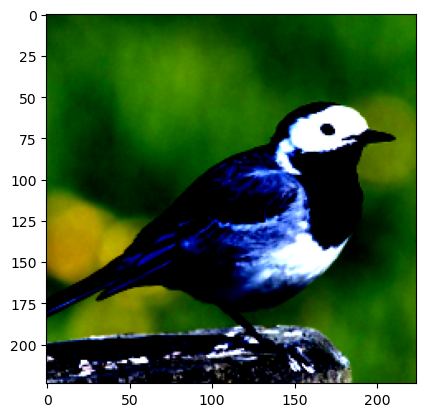

  0%|          | 2/2771 [00:02<49:01,  1.06s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


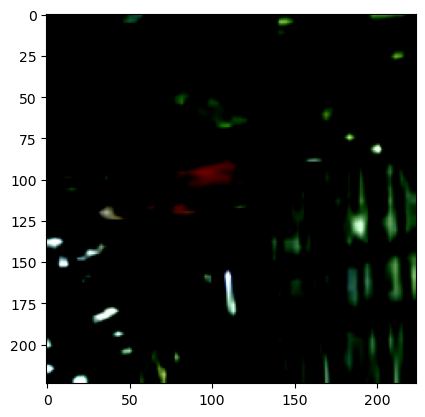

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


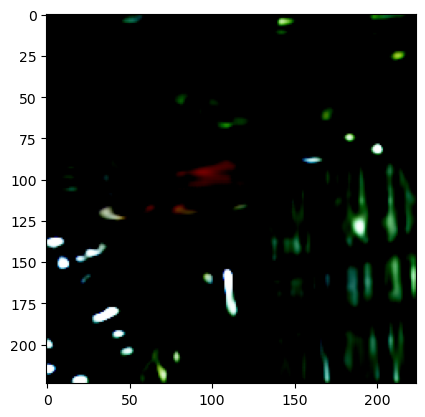

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


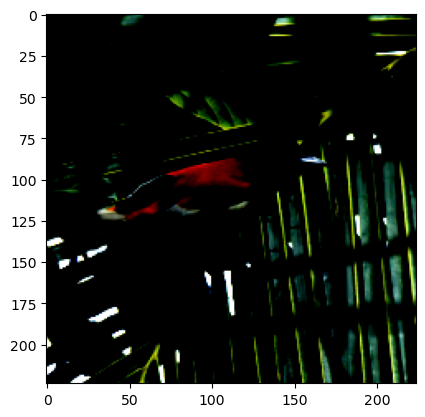

  0%|          | 3/2771 [00:03<48:32,  1.05s/it]


In [17]:
import torchvision.transforms as T
from PIL import Image

img_transform = T.ToPILImage()
cnt = 0
for imgs, labels in tqdm(iter(uptrain_loader)):
    if cnt == 3:
        break
    else:
        custom_imshow(imgs)
        custom_imshow(model.forward(imgs).detach())
        custom_imshow(labels)
        cnt += 1


### U-Net을 활용해서 화질이 올라간 것을 확인할 수 있다.
따라서 대략적으로 학습한 다음 분류 모델을 만든다.

In [18]:
class CNN(nn.Module):
    def __init__(self, num_classes=25):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 128 * 28 * 28)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x
cls_model = CNN().to(device)
# Loss function과 optimizer 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cls_model.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    for images, labels in tqdm(iter(train_loader)):
        images = model.forward(images)
        images, labels = images.to(device), labels.to(device)
        # Forward pass
        outputs = cls_model(images)
        loss = criterion(outputs, labels)

        # Backward pass 및 최적화
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

  0%|          | 1/2771 [00:04<3:34:31,  4.65s/it]

Epoch [1/10], Loss: 3.1877


  0%|          | 2/2771 [00:06<2:22:52,  3.10s/it]

Epoch [1/10], Loss: 10.3250


  0%|          | 3/2771 [00:08<1:59:38,  2.59s/it]

Epoch [1/10], Loss: 10.8528


  0%|          | 4/2771 [00:10<1:49:06,  2.37s/it]

Epoch [1/10], Loss: 4.0687


  0%|          | 5/2771 [00:12<1:43:06,  2.24s/it]

Epoch [1/10], Loss: 3.1822


  0%|          | 6/2771 [00:14<1:39:25,  2.16s/it]

Epoch [1/10], Loss: 3.2988


  0%|          | 7/2771 [00:16<1:37:05,  2.11s/it]

Epoch [1/10], Loss: 3.1648


  0%|          | 8/2771 [00:18<1:35:40,  2.08s/it]

Epoch [1/10], Loss: 3.2228


  0%|          | 9/2771 [00:20<1:35:00,  2.06s/it]

Epoch [1/10], Loss: 3.2378


  0%|          | 10/2771 [00:22<1:34:34,  2.06s/it]

Epoch [1/10], Loss: 3.2104


  0%|          | 11/2771 [00:24<1:34:02,  2.04s/it]

Epoch [1/10], Loss: 3.2555


  0%|          | 12/2771 [00:26<1:34:02,  2.05s/it]

Epoch [1/10], Loss: 3.1936


  0%|          | 13/2771 [00:28<1:33:42,  2.04s/it]

Epoch [1/10], Loss: 3.1946


  1%|          | 14/2771 [00:30<1:33:36,  2.04s/it]

Epoch [1/10], Loss: 3.2393


  1%|          | 15/2771 [00:32<1:33:46,  2.04s/it]

Epoch [1/10], Loss: 3.2250


  1%|          | 16/2771 [00:34<1:33:42,  2.04s/it]

Epoch [1/10], Loss: 3.1602


  1%|          | 17/2771 [00:37<1:33:29,  2.04s/it]

Epoch [1/10], Loss: 3.2085


  1%|          | 18/2771 [00:39<1:33:36,  2.04s/it]

Epoch [1/10], Loss: 3.1983


  1%|          | 19/2771 [00:41<1:33:19,  2.03s/it]

Epoch [1/10], Loss: 3.2378


  1%|          | 20/2771 [00:43<1:36:06,  2.10s/it]

Epoch [1/10], Loss: 3.0134


  1%|          | 21/2771 [00:45<1:37:54,  2.14s/it]

Epoch [1/10], Loss: 2.9700


  1%|          | 22/2771 [00:47<1:39:28,  2.17s/it]

Epoch [1/10], Loss: 3.0420


  1%|          | 23/2771 [00:50<1:39:53,  2.18s/it]

Epoch [1/10], Loss: 3.3512


  1%|          | 24/2771 [00:52<1:39:40,  2.18s/it]

Epoch [1/10], Loss: 3.8449


  1%|          | 25/2771 [00:54<1:40:07,  2.19s/it]

Epoch [1/10], Loss: 3.0917


  1%|          | 26/2771 [00:56<1:40:31,  2.20s/it]

Epoch [1/10], Loss: 3.8578


  1%|          | 27/2771 [00:58<1:41:07,  2.21s/it]

Epoch [1/10], Loss: 3.6222


  1%|          | 27/2771 [01:01<1:43:24,  2.26s/it]


KeyboardInterrupt: 

In [ ]:
torch.save(cls_model.state_dict(), './cls1')
